In [78]:
import openmeteo_requests

import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry
from datetime import datetime, timedelta

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

data_fetched = ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation"]
column_names = ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation"]

def fetchForecast(latitude = 52.52, longitude = 13.41, past_days = 92, forecast_days = 1, model = "ecmwf_ifs04"):
	url = "https://previous-runs-api.open-meteo.com/v1/forecast"
	params = {
		"latitude": latitude,
		"longitude": longitude,
		"past_days": past_days,
		"forecast_days": forecast_days,
		"hourly": data_fetched,
		"models": model
	}
	responses = openmeteo.weather_api(url, params=params)
	# Process hourly data. The order of variables needs to be the same as requested.
	response = responses[0]
	hourly = response.Hourly()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	for i, col_name in enumerate(column_names):
		hourly_data[col_name] = hourly.Variables(i).ValuesAsNumpy()
		
	hourly_dataframe = pd.DataFrame(data = hourly_data)
	return hourly_dataframe.dropna()

def fetchArchive(latitude = 52.52, longitude = 13.41, start_date = "2024-03-10", end_date = "2024-06-10"):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": latitude,
		"longitude": longitude,
		"start_date": start_date,
		"end_date": end_date,
		"hourly": data_fetched
	}
	responses = openmeteo.weather_api(url, params=params)
	# Process hourly data. The order of variables needs to be the same as requested.
	response = responses[0]
	hourly = response.Hourly()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	for i, col_name in enumerate(column_names):
		hourly_data[col_name] = hourly.Variables(i).ValuesAsNumpy()

	hourly_dataframe = pd.DataFrame(data = hourly_data)
	return hourly_dataframe.dropna()

def getForecastAndArchive(pastDays, model = "ecmwf_ifs04"):
    date_x_days_ago = datetime.now() - timedelta(days=pastDays)
    formatted_date = date_x_days_ago.strftime('%Y-%m-%d')

    forecast = fetchForecast(past_days=pastDays, model=model)
    archive = fetchArchive(start_date=formatted_date)
    forecast = forecast[:len(archive)]
    return forecast, archive

def calulateDiff(pastDays, model = "ecmwf_ifs04"):
    forecast, archive = getForecastAndArchive(pastDays, model)
    diff = forecast.drop(columns=["date"]) - archive.drop(columns=["date"])
    diff = diff.abs()
    relative_diff = diff / archive.drop(columns=["date"])
    relative_diff = relative_diff.abs()
    diff["date"] = forecast["date"]
    relative_diff["date"] = forecast["date"]
    return diff, relative_diff

def getAvgDiffByHour(diff):
    return diff.groupby(diff["date"].dt.hour)[[col for col in diff.columns if col != 'date']].mean().reset_index()

def getSoftMaxDiffByHour(diff):	  
	def soft_max(col):
		return (col - np.min(col)) / (np.max(col) - np.min(col))
	result = getAvgDiffByHour(diff).drop(columns=["date"]).apply(soft_max)
	result["date"] = range(0, 24)
	return result

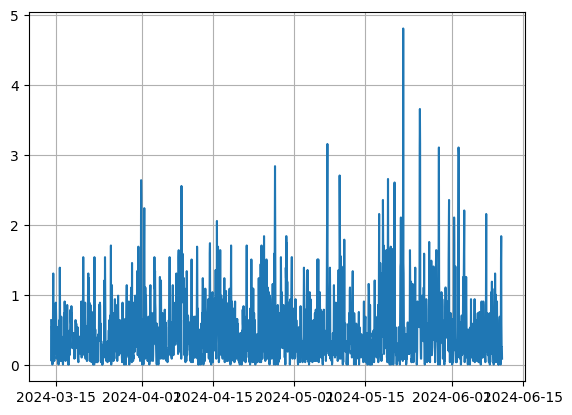

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plotTemperature(df, dateColumn = "date", tempColumn = "temperature_2m"):
    t = df[dateColumn]
    s = df[tempColumn]
    fig, ax = plt.subplots()
    ax.plot(t, s)
    ax.grid()
    plt.show()

diff, _ = calulateDiff(90)
plotTemperature(diff)

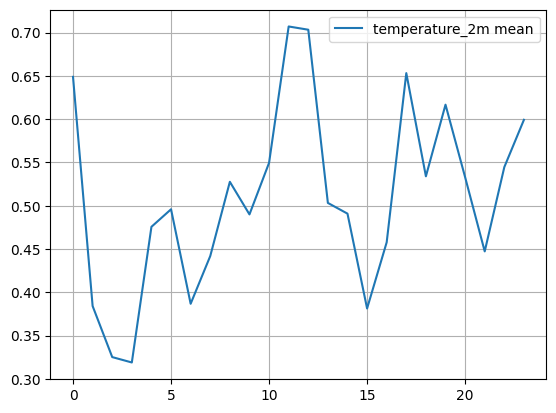

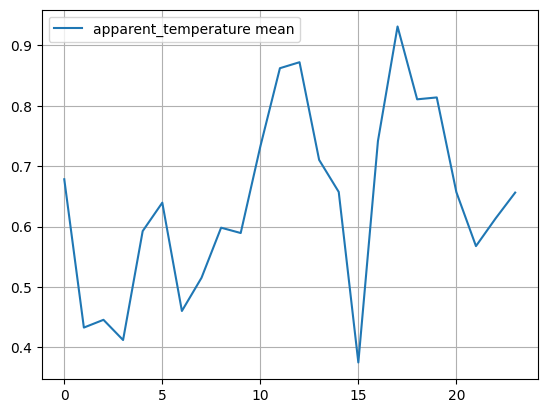

In [57]:
import matplotlib.pyplot as plt

def plotByHour(diff, column = "temperature_2m"):
    mean_diff = getAvgDiffByHour(diff)
    fig, ax = plt.subplots()
    ax.plot(mean_diff["date"], mean_diff[column], label= column + " mean")
    ax.grid()
    plt.legend()
    plt.show()

plotByHour(diff)
plotByHour(diff, "apparent_temperature")

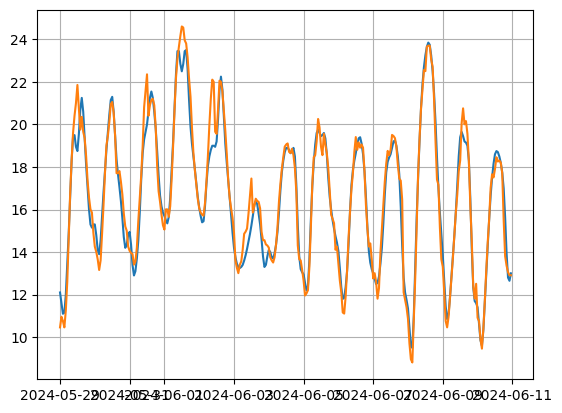

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def plotForecastAndArchive(forecast, archive, column = "temperature_2m"):
    _, ax = plt.subplots()
    ax.plot(forecast["date"], forecast[column])
    ax.plot(archive["date"], archive[column])
    ax.grid()
    plt.show()
# ax.plot(forecast["date"], forecast["precipitation"])
# ax.plot(archive["date"], archive["precipitation"])

# ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#        title='About as simple as it gets, folks')

forecast, archive = getForecastAndArchive(14)
plotForecastAndArchive(forecast, archive)

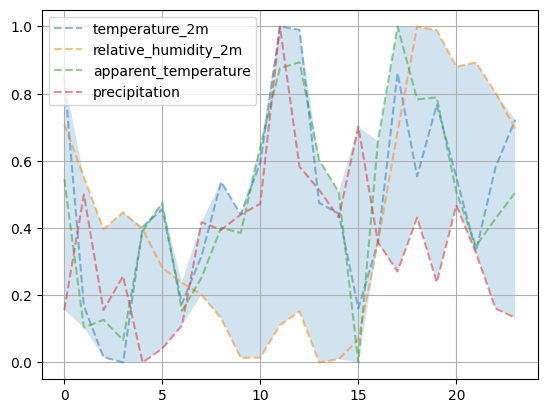

In [62]:
import numpy as np

diff, _ = calulateDiff(90)
softmax_data = getSoftMaxDiffByHour(diff).drop(columns=["date"])
date = range(0, 24)

_, ax = plt.subplots()
for col in softmax_data.columns:
    ax.plot(date, softmax_data[col], label=col, alpha = 0.5, linestyle='--')

ax.fill_between(date, 
                softmax_data.min(axis=1),
                softmax_data.max(axis=1), alpha = 0.2)
ax.grid()
plt.legend()
plt.show()

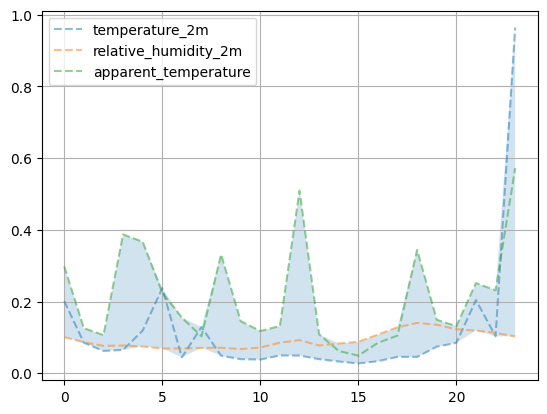

In [84]:
import numpy as np

_, relative_diff = calulateDiff(90)

mean_relative_diff = getAvgDiffByHour(relative_diff).drop(columns=["precipitation", "date"])
_, ax = plt.subplots()
date = range(0, 24)
    
for col in mean_relative_diff.columns:
    ax.plot(date, mean_relative_diff[col], label=col, alpha = 0.5, linestyle='--')

ax.fill_between(date, 
                mean_relative_diff.min(axis=1),
                mean_relative_diff.max(axis=1), alpha = 0.2)
ax.grid()
plt.legend()
plt.show()